In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn

from utils.constants import MAX_LEN, SEED


BATCH_SIZE = 16
NUM_EPOCHS = 10
PATIENCE = 5
VAL_EVERY_N_EPOCHS = 1

EMBEDDING_SIZE = 768
HIDDEN_SIZE = 256
NUM_LAYERS = 4
INPUT_SIZE = 768
BIDIRECTIONAL = True

NUM_CLASSES = 3  # 0 - Positive, 1 - Negative, 2 - Neutral

CHECKPOINT_DIR = 'checkpoints'
LR = 1e-5

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

criterion = nn.CrossEntropyLoss()

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [2]:
import pandas as pd
from utils import stratified_downsample

train_df = pd.read_csv("./data/train.csv", lineterminator="\n")
train_df = stratified_downsample(train_df, "sentiment")

val_df = pd.read_csv("./data/validation.csv", lineterminator="\n")
val_df = stratified_downsample(val_df, "sentiment")

test_df = pd.read_csv("./data/test.csv", lineterminator="\n")
test_df = stratified_downsample(test_df, "sentiment")

In [3]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from utils import build_vocab

LEMMATIZER = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

STOPWORDS_EN = set(stopwords.words('english'))
NEGATION_WORDS = {"n't", "not", "no", "never"}
PUNCTUATION = set(string.punctuation)

VOCAB = build_vocab(train_df.text, lemmatizer=LEMMATIZER, lemmatizer_func="lemmatize", negation_words=NEGATION_WORDS, punctuation=PUNCTUATION, stop_words=STOPWORDS_EN, k=20_000)
VOCAB_SIZE = len(list(VOCAB.keys()))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


🔍 Building vocabulary...


Tokenizing texts: 100%|██████████| 427288/427288 [00:51<00:00, 8279.47it/s]

✅ Vocab built with 20002 tokens (including specials)


In [5]:
%reload_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader

from dataset.bluesky_dataset import BlueSkyDataset
from models.rnn import RNNTextClassifier

from utils import get_device

train_dataset = BlueSkyDataset(vocab=VOCAB, posts=train_df, max_len=MAX_LEN, lemmatizer=LEMMATIZER, lemmatizer_func="lemmatize")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = BlueSkyDataset(vocab=VOCAB, posts=val_df, max_len=MAX_LEN, lemmatizer=LEMMATIZER, lemmatizer_func="lemmatize")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = BlueSkyDataset(vocab=VOCAB, posts=test_df, max_len=MAX_LEN, lemmatizer=LEMMATIZER, lemmatizer_func="lemmatize")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = get_device()

model = RNNTextClassifier(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDING_SIZE,
                          input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE,
                          num_layers=NUM_LAYERS,
                          bidirectional=BIDIRECTIONAL, num_classes=NUM_CLASSES)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(
    f"DATASET\n\t- Batch size: {BATCH_SIZE}\n\t- Train dataset size: {len(train_dataset)}\n\t- Validation dataset size: {len(val_dataset)}\n\t- Test dataset size: {len(test_dataset)}")
print("=" * 50)
print(
    f"MODEL\n\t- EPOCHS: {NUM_EPOCHS}\n\t- LEARNING RATE: {LR}\n\t- HIDDEN SIZE: {HIDDEN_SIZE}\n\t- NUM_LAYERS: {NUM_LAYERS}\n\t- BIDIRECTIONAL: {BIDIRECTIONAL}\n\t- VOCAB SIZE: {VOCAB_SIZE}\n\t- EMBEDDING SIZE: {EMBEDDING_SIZE}")

model = model.to(device)
model.train()

torch.autograd.set_detect_anomaly(True)

best_val_loss = float("inf")
curr_patience = 0

print("=" * 50)
print("Starting training...")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    if curr_patience >= PATIENCE:
        print(f"Patience reached after {PATIENCE} epochs. Stopping training...")
        break

    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}", leave=False)
    for x_batch, y_batch in progress_bar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)  # multiply by batch size to sum loss over samples
        preds = outputs.argmax(dim=1)
        total_correct += (preds == y_batch).sum().item()
        total_samples += y_batch.size(0)

        accuracy = total_correct / total_samples
        avg_loss = total_loss / total_samples

        progress_bar.set_postfix({"train_loss_step": loss.item(), "train_accuracy_step": accuracy})

    epoch_loss = total_loss / total_samples
    epoch_accuracy = total_correct / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"✅ Epoch {epoch + 1}/{NUM_EPOCHS} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.4f}")

    if epoch % VAL_EVERY_N_EPOCHS == 0:
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0

        progress_bar = tqdm(val_dataloader, desc=f"Validation step {epoch + 1}/{NUM_EPOCHS}", leave=False)
        with torch.no_grad():
            for x_val, y_val in progress_bar:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                outputs = model(x_val)
                loss = criterion(outputs, y_val)

                val_loss += loss.item() * x_val.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_val).sum().item()
                val_samples += y_val.size(0)

                val_accuracy_step = (preds == y_val).float().mean().item()
                progress_bar.set_postfix({"val_loss_step": loss.item(), "val_accuracy_step": val_accuracy_step})

        val_loss /= val_samples
        val_accuracy = val_correct / val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"🔍 Validation | Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f}\n")

        if val_loss < best_val_loss:
            print("=" * 50)
            print(f"New best score reached. Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"rnn_val_loss_{val_loss:.4f}_epoch_{epoch + 1}.pt")
            print(f"Saving checkpoint to {checkpoint_path}")
            print("=" * 50)
            torch.save(model.state_dict(), checkpoint_path)
            best_val_loss = val_loss
            curr_patience = 0
        else:
            curr_patience += 1

print("=" * 50)
print(f"Training finished. Best val loss reached: {best_val_loss:.4f} - Checkpoints saved at {checkpoint_path}")

DATASET
	- Batch size: 16
	- Train dataset size: 427288
	- Validation dataset size: 91562
	- Test dataset size: 91562
MODEL
	- EPOCHS: 10
	- LEARNING RATE: 1e-05
	- HIDDEN SIZE: 256
	- NUM_LAYERS: 4
	- BIDIRECTIONAL: True
	- VOCAB SIZE: 20002
	- EMBEDDING SIZE: 768
Starting training...


KeyboardInterrupt: 

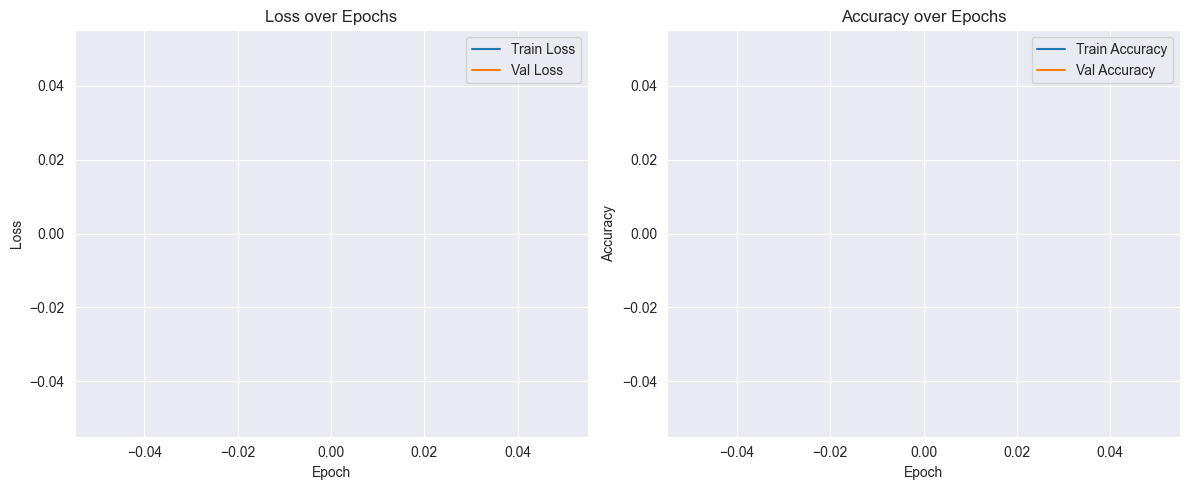

In [12]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    Negative       0.27      0.31      0.29     22918
     Neutral       0.37      0.41      0.39     33388
    Positive       0.47      0.37      0.42     35256

    accuracy                           0.37     91562
   macro avg       0.37      0.36      0.36     91562
weighted avg       0.38      0.37      0.37     91562



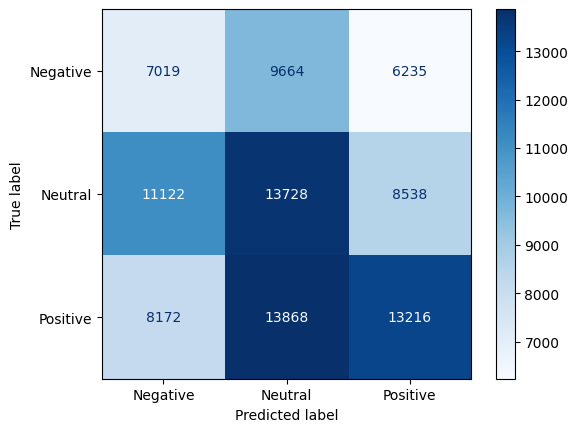

In [6]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import torch
from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load("checkpoints/rnn_val_loss_0.9408_epoch_10.pt", map_location=device)
model = model.to(device)
model.load_state_dict(state_dict)

y_preds = []
y_true = []

progress_bar = tqdm(test_dataloader, desc="Testing", leave=False)

for x_batch, y_batch in progress_bar:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    
    with torch.no_grad():
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
    
    y_preds.append(predictions.cpu())
    y_true.append(y_batch.cpu())

y_preds = torch.cat(y_preds).numpy()
y_true = torch.cat(y_true).numpy()

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
labels = [label_map[i] for i in sorted(label_map.keys())]

# Report
print(classification_report(y_true, y_preds, target_names=labels))

ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels=labels, cmap='Blues')